In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
from resizeimage import resizeimage
import cv2
import os
from IPython.display import clear_output
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from time import time
from sklearn.model_selection import GridSearchCV

Importamos los datos que vamos a usar. Los X_train/test es una matriz con N=número de datos filas y P=224x224=número de pixeles por imagen columnas. Los y_train/test son vectores de largo N=número de datos con 0(no tiene neumonía), 1(tiene neumonía bacteriana) y 2(tiene neumonía viral)

In [17]:
X_train = np.load("data_pca/X_pca_3clases.npy")
X_test = np.load("data_pca/X_pca_test_3clases.npy")
y_train = np.load("data_pca/y_train_rec_3clases.npy")
y_test = np.load("data_pca/y_test_3clases.npy")
#y_train_oh = np.load("data_pca/y_train_oh_3clases")


Hacemos un y_train one-hot encodeado. Es decir, tomamos los y con 0 1 y 2 y los convertimos en una matriz de N por 3 con un 1 en la clase correspondiente. Primer cada columna equivale a las etiquetas 0 1 y 2 respectivamente

In [18]:
print(y_train.shape)


y_train_oh = np.zeros(shape=(y_train.shape[0], 3), dtype=int)

for index, val in enumerate(y_train):
    if val == 0:
        y_train_oh[index, 0] += int(1)
    elif val == 1:
        y_train_oh[index, 1] += int(1)
    elif val == 2:
        y_train_oh[index, 2] += int(1)
        

print(y_train_oh)

(4031,)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [19]:
print(y_test)
y_train_int = y_train.astype(int)
print(y_train_int)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Separamos los datos de X_train en distintas matrices que contienen los datos sólo de una clase: una para normales, otra para bacterianos y otra para virales. Además hacemos que cada una de estas matrices tenga aproximadamente la misma cantidad de datos para cada clase.

In [20]:
X_nor = X_train[:1341,:]
X_bac = X_train[1341:-1345,:]
X_vir = X_train[-1345:,:]


y_nor = y_train_oh[:1341, 0]
y_bac = y_train_oh[1341:-1345, 1]
y_vir = y_train_oh[-1345:, 2]

X_nor_bac = np.concatenate([X_nor, X_bac])
y_nor_bac = np.concatenate([y_nor, y_bac])
print(y_nor_bac.any() == 0)

False


Hacemos un X_train binario con su correspondiente y_train binario, es decir, eliminamos la diferencia entre clases bacteriana y viral y las juntamos en una única clase: positivos.

In [ ]:
X_pos = np.concatenate([X_train[1341:1341+675], X_train[-675]])

X_train_binario = np.concatenate([X_nor, X_pos])
y_train_binario = np.concatenate([np.zeros(X_nor.shape[0]), np.ones(X_pos.shape[0])])

Definimos la variable del fit

In [31]:
svm = SVC(kernel="rbf", C=1.75, max_iter=-1)

Probamos el fit con un parámetro cualquiera

In [32]:
svm.fit(X_train, y_train)
score = svm.score(X_test, y_test)
print(score)

0.7243589743589743


Hacemos un barrido para el parámetro C y vemos cual es el óptimo haciendo k-fold

In [29]:
svm = SVC(kernel = "rbf", max_iter = 100000)
param = {"C":tuple(np.arange(1.6 , 2, 0.05))}
svm.grid = GridSearchCV(svm, param, n_jobs=1, cv=10, verbose=1, scoring="balanced_accuracy")
svm.grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=SVC(max_iter=100000), n_jobs=1,
             param_grid={'C': (1.6, 1.6500000000000001, 1.7000000000000002,
                               1.7500000000000002, 1.8000000000000003,
                               1.8500000000000003, 1.9000000000000004,
                               1.9500000000000004)},
             scoring='balanced_accuracy', verbose=1)

Vemos que el parámetro óptimo es 1.75

In [30]:
svm.grid.best_params_

{'C': 1.7500000000000002}

Definimos una función que shufflea dos arrays en paralelo

In [2]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Entrenamos el modelo con el parámetro encontrado y lo testeamos en el dataset de testeo para el caso con las clases bacterianas y virales distinguidas

In [34]:
X_train, y_train = unison_shuffled_copies(X_train, y_train)
svm = SVC(kernel="rbf", C=1.75)
svm.fit(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)
score = svm.score(X_test, y_test)
print(score)

0.7243589743589743


In [38]:
y_test_predict = svm.predict(X_test)

Vemos la confusion matrix

In [47]:
cm = confusion_matrix(y_test, y_test_predict)
print('Confusion Matrix\n')
print(cm)
y_pred = y_test_predict

Confusion Matrix

[[110  16 108]
 [  1 220  21]
 [  5  21 122]]


Vemos mas parámetros de que tan bueno es el modelo

In [48]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))


Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Macro Precision: 0.76
Macro Recall: 0.73
Macro F1-score: 0.71

Weighted Precision: 0.80
Weighted Recall: 0.72
Weighted F1-score: 0.72

Classification Report

              precision    recall  f1-score   support

     Class 1       0.95      0.47      0.63       234
     Class 2       0.86      0.91      0.88       242
     Class 3       0.49      0.82      0.61       148

    accuracy                           0.72       624
   macro avg       0.76      0.73      0.71       624
weighted avg       0.80      0.72      0.72       624



# Hacemos SVM sin hacer PCA

Importamos los datos

In [3]:
X_bac = np.load("data_raw/X_bac.npy")
X_vir = np.load("data_raw/X_vir.npy")
X_nor = np.load("data_raw/X_nor.npy")

print(X_bac.shape, X_nor.shape, X_vir.shape)

(2530, 50176) (1341, 50176) (1345, 50176)


Armo el dataset de train y de test

In [28]:
X_bac_test = X_bac[-200:,:]
X_vir_test = X_vir[-200:,:]
X_nor_test = X_nor[-200:,:]

X_bac_train = X_bac[:1345-200,:]
X_vir_train = X_vir[:-200,:]
X_nor_train = X_nor[:-200,:]

print("Shape trains: bac, vir, nor \n",X_bac_train.shape, X_vir_train.shape, X_nor_train.shape)
print("Shape test: bac, vir, nor \n",X_bac_test.shape, X_vir_test.shape, X_nor_test.shape)

X_test = np.concatenate([X_nor_test, X_bac_test, X_vir_test])
X_train = np.concatenate([X_nor_train, X_bac_train, X_vir_train])

#genero los vectores y_train y y_test

y_nor_test = np.zeros(200)
y_bac_test = np.ones(200)
y_vir_test = np.ones(200)*2

y_nor_train = np.zeros(X_nor_train.shape[0])
y_bac_train = np.ones(X_bac_train.shape[0])
y_vir_train = np.ones(X_vir_train.shape[0])*2

y_test = np.concatenate([y_nor_test, y_bac_test, y_vir_test])
y_train = np.concatenate([y_nor_train, y_bac_train, y_vir_train])

#shuffleo los datos

X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

print("Shape train:", X_train.shape, y_train.shape)
print("Shape test:", X_test.shape, y_test.shape)

Shape trains: bac, vir, nor 
 (1145, 50176) (1145, 50176) (1141, 50176)
Shape test: bac, vir, nor 
 (200, 50176) (200, 50176) (200, 50176)
Shape train: (3431, 50176) (3431,)
Shape test: (600, 50176) (600,)


Recorto las imagenes de X_train de 224x224 a lado_imgxlado_img

In [38]:
lado_img = 80

X_train_recortado = np.zeros(shape=(X_train.shape[0], lado_img**2))

for index, imagen in enumerate(X_train):
    imagen = cv2.resize(imagen.reshape(224,224), (lado_img, lado_img)).reshape(-1)
    X_train_recortado[index, :] += imagen

Visualizamos el resultado

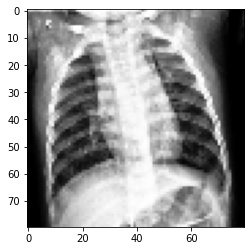

In [39]:
plt.imshow(X_train_recortado[6,:].reshape(lado_img, lado_img), cmap="Greys_r")
plt.show()

Hacemos lo mismo para X_test

In [40]:

X_test_recortado = np.zeros(shape=(X_test.shape[0], lado_img**2))

for index, imagen in enumerate(X_test):
    imagen = cv2.resize(imagen.reshape(224,224), (lado_img, lado_img)).reshape(-1)
    X_test_recortado[index, :] += imagen

Idem

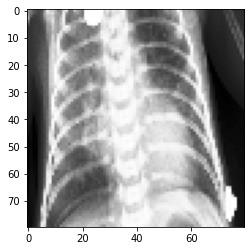

In [41]:
plt.imshow(X_test_recortado[6,:].reshape(lado_img, lado_img), cmap="Greys_r")
plt.show()

Cuento la cantidad de elementos que hay para cada clase en X_train_recortado

In [42]:
print("Sin neumonía",X_train_recortado[y_train == 0].shape[0],
      "\nBacteriana", X_train_recortado[y_train == 1].shape[0],
      "\nViral",X_train_recortado[y_train == 2].shape[0])

Sin neumonía 1141 
Bacteriana 1145 
Viral 1145


Ahora hago SVM

In [43]:
#X_train_rec_shuf, y_train_shuf = unison_shuffled_copies(X_train_recortado, y_train)
svm = SVC(kernel="rbf", C=0.1)
svm.fit(X_train_recortado, y_train)
#X_test_rec, y_test = unison_shuffled_copies(X_test_recortado, y_test)
score = svm.score(X_test_recortado, y_test)
print(score)

0.7566666666666667


Vemos parámetros de ajuste

In [44]:
y_test_predict = svm.predict(X_test_recortado)

In [45]:
cm = confusion_matrix(y_test, y_test_predict)
print('Confusion Matrix\n')
print(cm)
y_pred = y_test_predict

Confusion Matrix

[[192   1   7]
 [ 10 151  39]
 [ 16  73 111]]


In [46]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.75
Macro Recall: 0.76
Macro F1-score: 0.75

Weighted Precision: 0.75
Weighted Recall: 0.76
Weighted F1-score: 0.75

Classification Report

              precision    recall  f1-score   support

     Class 1       0.88      0.96      0.92       200
     Class 2       0.67      0.76      0.71       200
     Class 3       0.71      0.56      0.62       200

    accuracy                           0.76       600
   macro avg       0.75      0.76      0.75       600
weighted avg       0.75      0.76      0.75       600

